# Kwame's Zillow Zestimates Error Control

Table of contents with header links goes here.

## explore.ipynb

### When this section of the pipeline is done being coded, I will transfer internal code to ```explore.py``` and external code and output to the final notebook.

**I may make this the final notebook with a rename and cleanup.**

### Set up the environment

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# import necessary packages/modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import sqrt

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, TweedieRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import IsolationForest

from wrangle import get_zillow_data, prepare_zillow
from preprocessing import zillow_main_split, zillow_Xy_split, impute_nulls, zillow_scale, isolation_forest, concat_dfs
from explore import viz_logerror, corr_heatmap, ttest_viz, ttest_hypo
from model import create_cluster_area, cluster_area_viz, choose_k, intertia_k

# default viz size settings
plt.rc('figure', figsize=(9, 7))
plt.rc('font', size=13)

# default pandas decimal number display format
#pd.options.display.float_format = '{:20,.2f}'.format

### Acquire the data

In [2]:
df = get_zillow_data()
df.shape

(77580, 69)

### Tidy the data

In [3]:
df = prepare_zillow(df)
df.head(3)

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,logerror,bathbedcnt,decade,century
parcelid,,,,,,,,,,,
14297519,3.50,"3,100.00","33,634,931.00","-117,869,207.00",1,"1,998.00","1,023,282.00",0.03,7.50,199.00,19.00
17052889,1.00,"1,465.00","34,449,266.00","-119,281,531.00",2,"1,967.00","464,000.00",0.06,3.00,196.00,19.00
14186244,2.00,"1,243.00","33,886,168.00","-117,823,170.00",1,"1,962.00","564,778.00",0.01,5.00,196.00,19.00


### Summarize the clean data

In [4]:
df.shape

(52296, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52296 entries, 14297519 to 13083743
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bathcnt     52296 non-null  float64
 1   sqft        52291 non-null  float64
 2   latitude    52296 non-null  float64
 3   longitude   52296 non-null  float64
 4   county      52296 non-null  int64  
 5   yearbuilt   52296 non-null  float64
 6   value       52295 non-null  float64
 7   logerror    52296 non-null  float64
 8   bathbedcnt  52296 non-null  float64
 9   decade      52296 non-null  float64
 10  century     52296 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 4.8 MB


In [6]:
df.isnull().sum()

bathcnt       0
sqft          5
latitude      0
longitude     0
county        0
yearbuilt     0
value         1
logerror      0
bathbedcnt    0
decade        0
century       0
dtype: int64

The remaining nulls have to be imputed after the data split so that we aren't cheating with our data sets.

### Split the data into train, validate, test.

In [7]:
# main split
train, validate, test = zillow_main_split(df)

In [8]:
print(f'Shape of train data: {train.shape}')
print(f'Shape of validate data: {validate.shape}')
print(f'Shape of test data: {test.shape}')

Shape of train data: (29285, 11)
Shape of validate data: (12551, 11)
Shape of test data: (10460, 11)


### Impute the remaining nulls with medians.

In [9]:
train = impute_nulls(train)
train.isnull().sum()

bathcnt       0
sqft          0
latitude      0
longitude     0
county        0
yearbuilt     0
value         0
logerror      0
bathbedcnt    0
decade        0
century       0
dtype: int64

In [10]:
validate = impute_nulls(validate)
validate.isnull().sum()

bathcnt       0
sqft          0
latitude      0
longitude     0
county        0
yearbuilt     0
value         0
logerror      0
bathbedcnt    0
decade        0
century       0
dtype: int64

In [11]:
test = impute_nulls(test)
test.isnull().sum()

bathcnt       0
sqft          0
latitude      0
longitude     0
county        0
yearbuilt     0
value         0
logerror      0
bathbedcnt    0
decade        0
century       0
dtype: int64

### Handle outliers

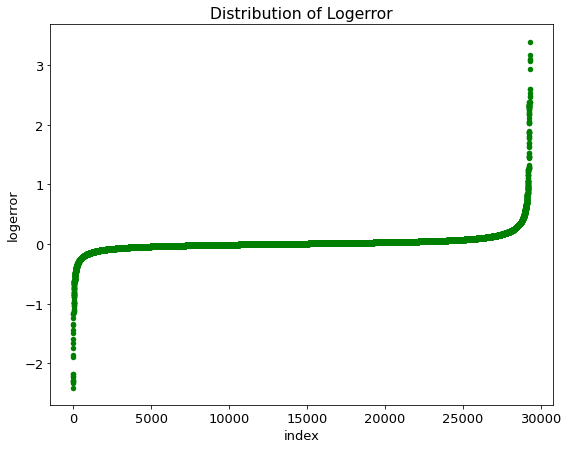

In [13]:
viz_logerror(train)

**There are outliers present on both ends.**

**Now that I'm on my second iteration through the data science pipeline, I will handle these outliers using an Isolation Forest that detects anomalies.**

In [14]:
print('Current shape of train:', train.shape)

Current shape of train: (29285, 11)


**Isolation Forest, or iForest for short, is a tree-based anomaly detection algorithm.**

In [15]:
# temporarily split data into X and y
X_train, X_validate, X_test, y_train, y_validate, y_test = zillow_Xy_split(train, validate, test)

In [16]:
# Isolation Forest
X_train, X_validate, X_test, y_train, y_validate, y_test = isolation_forest(X_train, X_validate, X_test, y_train, y_validate, y_test)

New shapes of train data: (20499, 10) (20499,)
Mean Absolute error on validate data: 0.070


In [17]:
# concat the dfs back together
train = concat_dfs(train, X_train, y_train)
validate = concat_dfs(validate, X_validate, y_validate)
test = concat_dfs(test, X_test, y_test)

Shape: (20499, 11)
Shape: (8786, 11)
Shape: (7322, 11)


In [56]:
# making sure my iForest didn't drop too much data
train.describe()

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century,logerror
count,"20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00"
mean,2.01,"1,609.59","33,996,145.94","-118,133,260.31",0.27,"1,957.99","377,767.65",5.15,195.34,19.00,0.02
std,0.66,529.73,"239,624.74","257,108.27",0.44,16.94,"292,678.26",1.26,1.69,0.00,0.16
min,0.00,152.00,"33,340,620.00","-118,852,072.00",0.00,"1,907.00","3,254.00",0.00,190.00,19.00,-2.33
25%,2.00,"1,219.00","33,830,043.50","-118,346,284.00",0.00,"1,949.00","158,306.00",4.00,194.00,19.00,-0.03
50%,2.00,"1,515.00","33,977,233.00","-118,119,533.00",0.00,"1,956.00","325,909.00",5.00,195.00,19.00,0.01
75%,2.50,"1,926.00","34,149,114.00","-117,934,277.50",1.00,"1,968.00","510,000.00",6.00,196.00,19.00,0.04
max,4.00,"3,720.00","34,758,939.00","-117,562,336.00",1.00,"1,999.00","4,080,000.00",10.00,199.00,19.00,3.18


**Now I'll visualize the distribution of log error again to check that the outliers were removed successfully.**

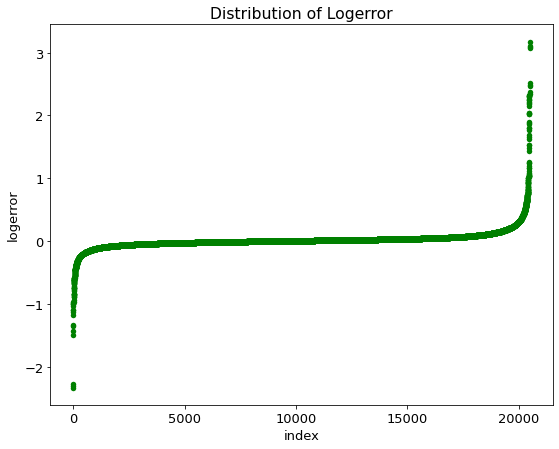

In [18]:
viz_logerror(train)

**Looks good, so let's move on to scaling the data.**

### Scale the data

In [19]:
scaler, train_scaled, validate_scaled, test_scaled = zillow_scale(train, validate, test)
train_scaled.head(3)

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century,logerror
parcelid,,,,,,,,,,,
13060986,0.50,0.58,0.49,0.81,0.00,0.63,0.14,0.60,0.67,0.00,0.42
11921805,0.50,0.44,0.56,0.60,0.00,0.26,0.22,0.50,0.33,0.00,0.43
11504971,0.75,0.62,0.39,0.35,0.00,0.64,0.03,0.80,0.67,0.00,0.43


### Explore the data and create visualizations

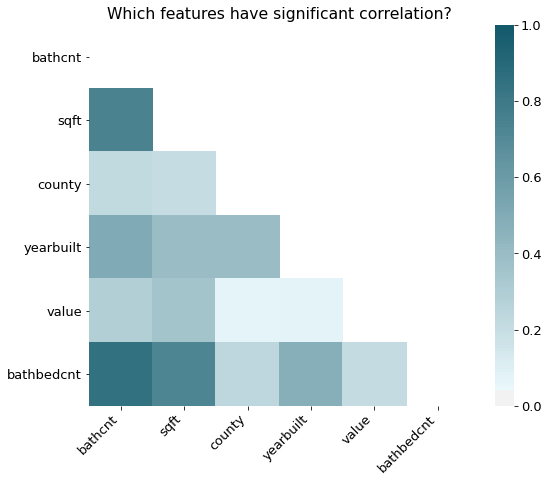

In [20]:
corr_heatmap(train_scaled.drop(columns=['logerror']))

Text(0.5, 1.0, 'Distribution of decade')

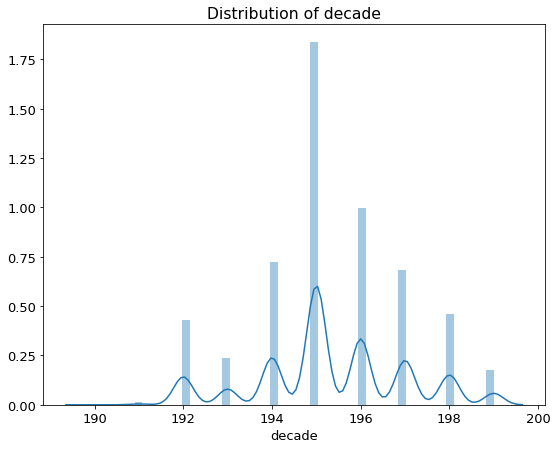

In [55]:
sns.distplot(train.decade)
plt.title('Distribution of decade')

Text(0.5, 1.0, 'Which properties have more log error, by year built bins and county?')

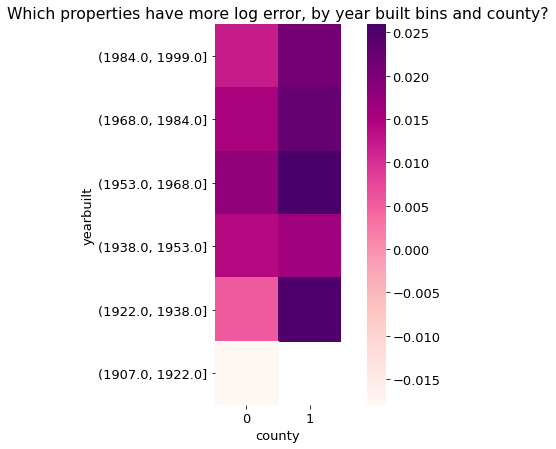

In [22]:
# pandas pivot
heatmap1_data = pd.pivot_table(train, values='logerror', 
                     index=pd.cut(train['yearbuilt'], bins=6, precision=0), 
                     columns='county')
heatmap1_data.sort_index(inplace=True, ascending=False)
sns.heatmap(heatmap1_data, cmap="RdPu", square=True)
plt.title('Which properties have more log error, by year built bins and county?')

Los Angeles: 0, Orange: 1, Ventura: 2

**Before I handled outliers:**
Looks like properties built in the 1800s and early 1900s have slightly more log error, especially in Ventura county. Granted, there are not very many properties that meet those criteria, so let's do a statisical test to find out if it's significant or not. There seems to be slightly more log error in Orange county.

**After I handled outliers:**
After I handled the outliers, it got rid of all the properties built before 1907. Now I see that there is actually less log error in the early 1900s. So I am adding a new hypothesis test regarding year built and getting rid of the old one ("There is a difference in Zestimate log error in properties built in the 1800s and the overall log error"), which is no longer applicable. I also noticed that my Isolation Forest dropped all Ventura county properties.

In [23]:
train.century.value_counts(dropna=False)

19.00    20499
Name: century, dtype: int64

**My iForest also dropped the 2,000 or so properties that were built in the 2000s.**

### 1-sample, 2-tailed T-test:

## Is there a significant difference in the log error of Zestimates on properties built in the 1800s and the overall log error?

$
\begin{align*}
   H_0 & : \text{There is no difference in Zestimate log error in properties built in the 1800s and the overall log error.}
   \\
   H_a & : \text{There is a difference in Zestimate log error in properties built in the 1800s and the overall log error.}
   \\
    \alpha & : \text{0.05}
\end{align*}
$

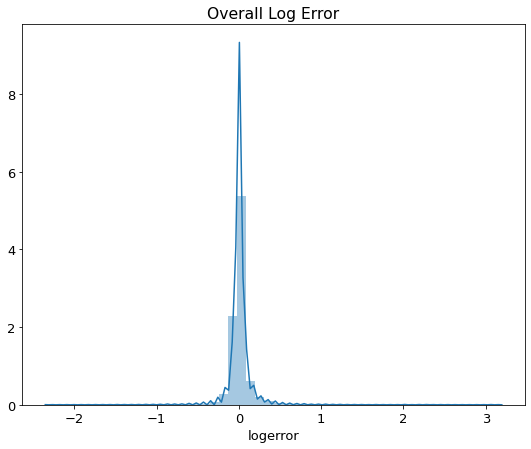

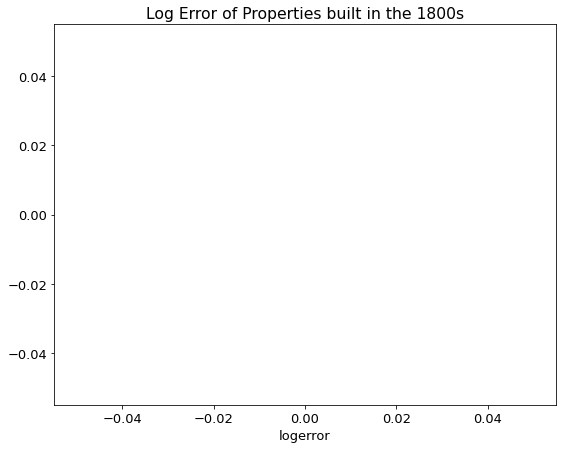

Compare the median and mean:
 0.016293312870376418 0.00583204246769


In [24]:
ttest_viz(train)

There are some outliers, but I will say that the mean and median are close enough for this iteration. I will remove outliers in the next iteration.

**Now that we know the variable has a normal distribution and we compared the mean and median, we can run the T-test.**

In [25]:
ttest_hypo(train)

t = nan
p = nan
We fail to reject the null hypothesis.


**There doesn't seem to be a statistically significant difference in log error in properties built in the 1800s and the overall log error.**

**However I do notice that the distribution of the log error of properties built in the 1800s is skewed differently from the overall log error.**

### Stats test 2?

In [26]:
train.columns

Index(['bathcnt', 'sqft', 'latitude', 'longitude', 'county', 'yearbuilt',
       'value', 'bathbedcnt', 'decade', 'century', 'logerror'],
      dtype='object')

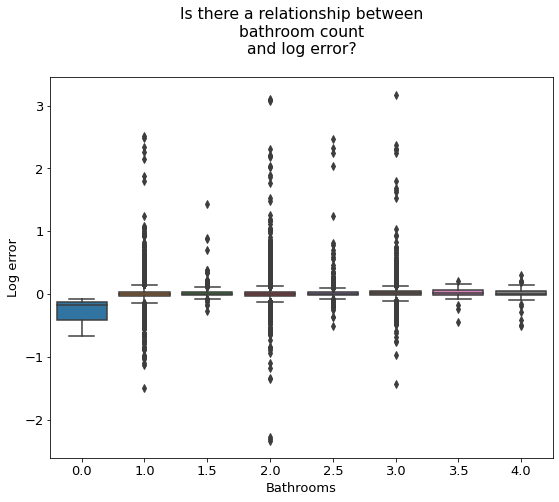

In [27]:
sns.boxplot(x="bathcnt", y="logerror", data=train)
plt.xlabel("Bathrooms")
plt.ylabel("Log error")
plt.title("Is there a relationship between\nbathroom count\nand log error?\n")
plt.show()

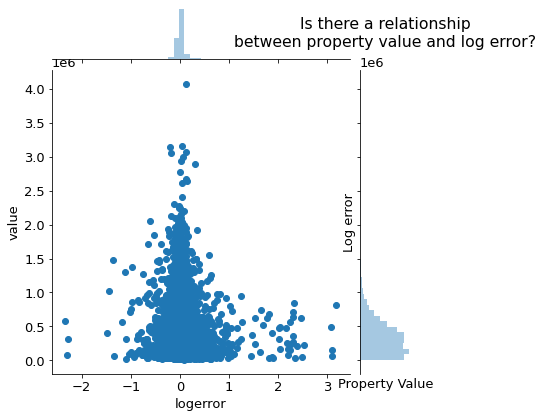

In [28]:
sns.jointplot(x="logerror", y="value", data=train)
plt.xlabel("Property Value")
plt.ylabel("Log error")
plt.title("Is there a relationship\nbetween property value and log error?\n")
plt.show()

It seems like there is definitely more error amongst lower value properties.

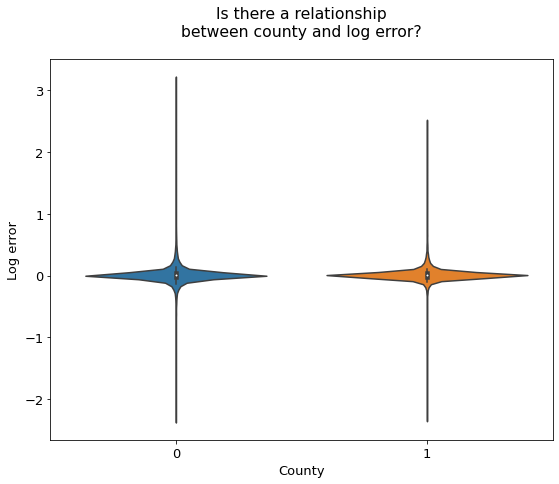

In [29]:
sns.violinplot(x="county", y="logerror", data=train)
plt.xlabel("County")
plt.ylabel("Log error")
plt.title("Is there a relationship\nbetween county and log error?\n")
plt.show()

More log error in Los Angeles county.

Text(0.5, 1.0, 'Distribution of Property Value')

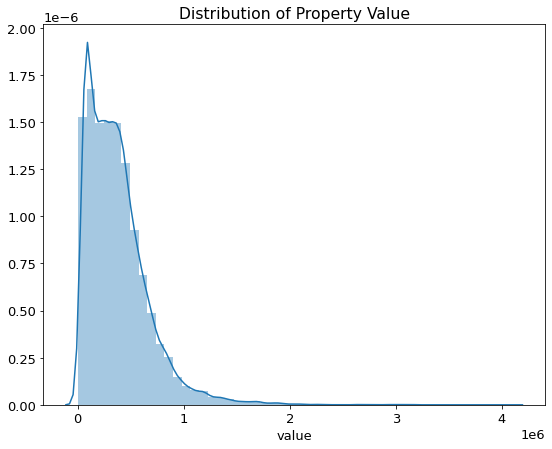

In [30]:
sns.distplot(train.value)
plt.title('Distribution of Property Value')

Value looks normally distributed enough, so I can run a Pearson's R test on this. I will do that statistical testing in the next iteration through the pipeline.

# Feature Engineering with Clustering

In [31]:
train_scaled.columns

Index(['bathcnt', 'sqft', 'latitude', 'longitude', 'county', 'yearbuilt',
       'value', 'bathbedcnt', 'decade', 'century', 'logerror'],
      dtype='object')

In [32]:
X = train_scaled[['latitude', 'longitude', 'county']]
Xv = validate_scaled[['latitude', 'longitude', 'county']]
Xt = test_scaled[['latitude', 'longitude', 'county']]
kmeans, centroids = create_cluster_area(train, train_scaled, validate, validate_scaled, test, test_scaled, X, Xv, Xt, 5)

In [33]:
train_scaled.groupby('cluster_area').mean()

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century,logerror
cluster_area,,,,,,,,,,,
0,0.43,0.36,0.41,0.48,0.00,0.44,0.08,0.46,0.48,0.00,0.43
1,0.56,0.46,0.28,0.77,1.00,0.68,0.10,0.56,0.72,0.00,0.43
2,0.51,0.38,0.90,0.58,0.00,0.75,0.04,0.53,0.78,0.00,0.43
3,0.53,0.43,0.61,0.30,0.00,0.52,0.11,0.52,0.56,0.00,0.43
4,0.49,0.40,0.51,0.70,0.00,0.54,0.08,0.51,0.58,0.00,0.43


In [34]:
train_scaled.groupby('cluster_area').median()

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century,logerror
cluster_area,,,,,,,,,,,
0,0.50,0.33,0.40,0.48,0.00,0.47,0.07,0.50,0.56,0.00,0.42
1,0.50,0.44,0.30,0.75,1.00,0.66,0.10,0.55,0.67,0.00,0.42
2,0.50,0.36,0.88,0.57,0.00,0.83,0.04,0.50,0.89,0.00,0.42
3,0.50,0.40,0.60,0.30,0.00,0.51,0.09,0.50,0.56,0.00,0.42
4,0.50,0.37,0.51,0.69,0.00,0.52,0.07,0.50,0.56,0.00,0.42


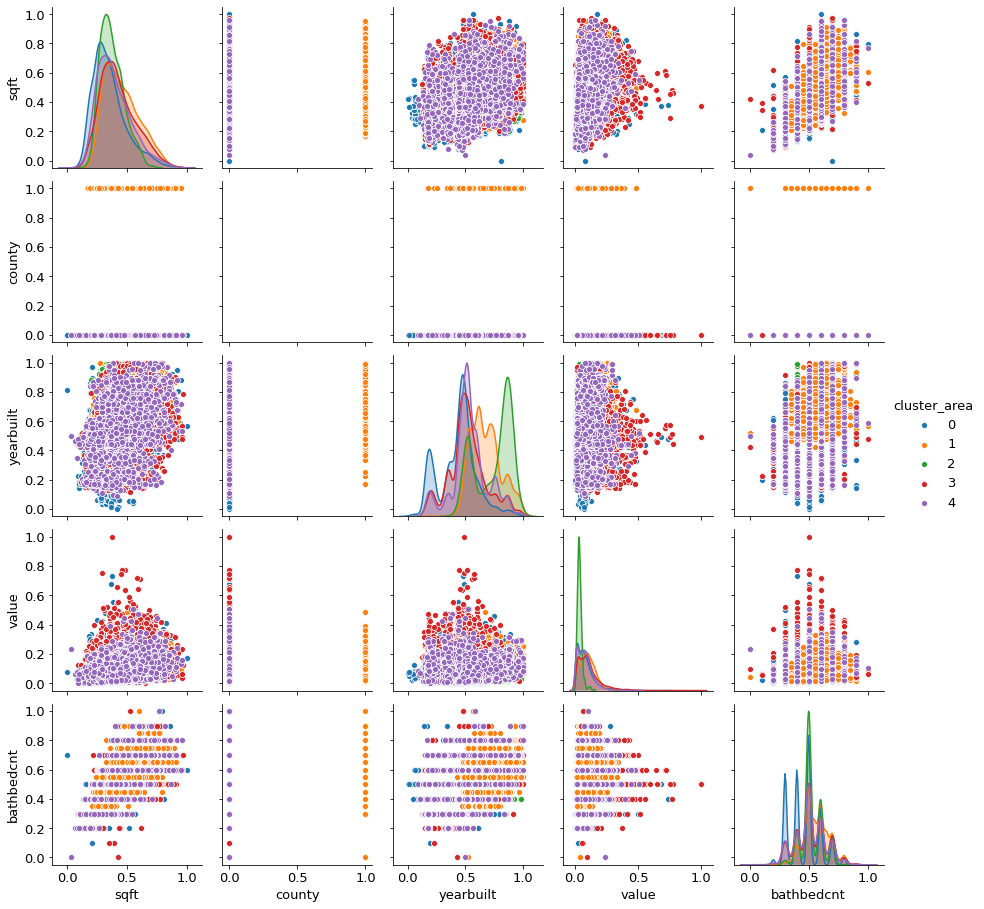

In [35]:
sns.pairplot(data=train_scaled.drop(columns=['latitude', 'longitude', 'century', 'decade', 'bathcnt', 'logerror']), hue='cluster_area')

**These clusters don't look super useful in distinguishing groups of like properties as of now.**

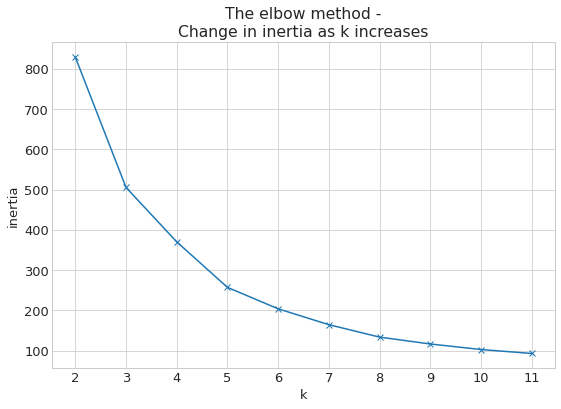

In [36]:
intertia_k(X)

**Judging by the elbow method, the sweet spot for my k-value should be around 4 or 5. I'll look closer with a visualization.**

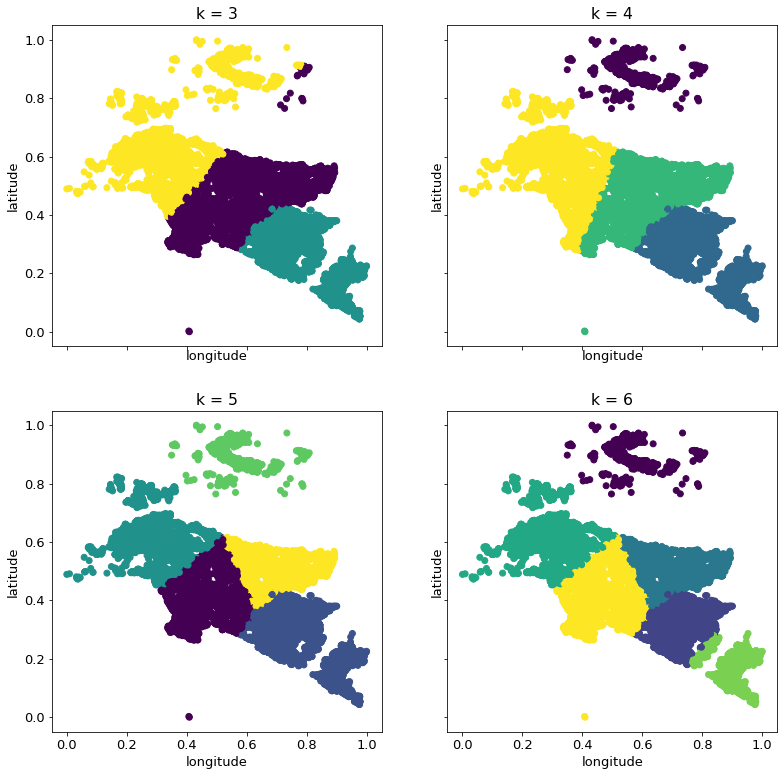

In [37]:
#X = train_scaled[['latitude', 'longitude', 'county']]

n_clusters=4
kmeans = KMeans(n_clusters, n_init=20).fit(X)

fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)
# this is usual because with one of the originals feature, county, we only get 3 groups.
# with kmeans clustering we can get more groups based on area.
# it's also helpful to get a more even distribution of the data per area
for ax, k in zip(axs.ravel(), range(3, 7)):
    clusters = KMeans(k).fit(X).predict(X)
    ax.scatter(X.longitude, X.latitude, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='longitude', ylabel='latitude')

**I actually really like the region clusters for ```k = 6```, so I'm going to use ```k = 6``` to re-create my new feature (cluster_area) to use in modeling.**

In [38]:
train = train.drop(columns=['cluster_area'])
train_scaled = train_scaled.drop(columns=['cluster_area'])

In [39]:
X = train_scaled[['latitude', 'longitude', 'county']]
Xv = validate_scaled[['latitude', 'longitude', 'county']]
Xt = test_scaled[['latitude', 'longitude', 'county']]
kmeans, centroids = create_cluster_area(train, train_scaled, validate, validate_scaled, test, test_scaled, X, Xv, Xt, 6)

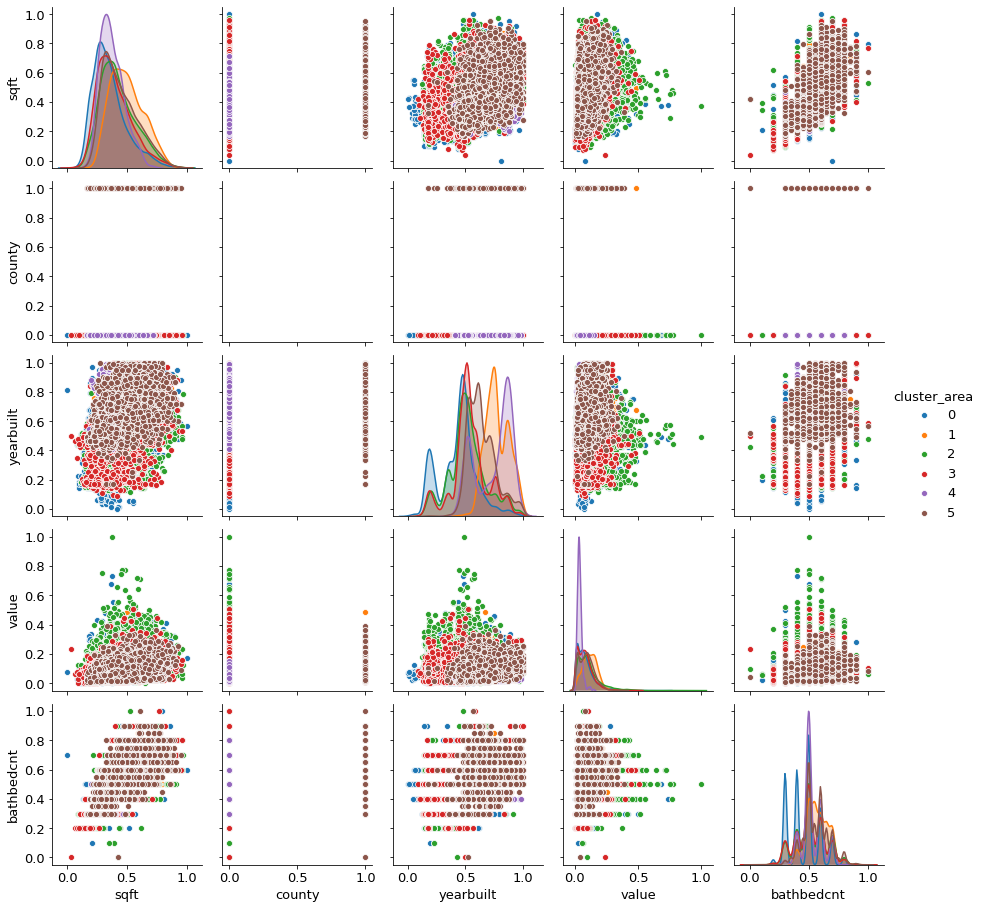

In [40]:
# Now I'll run pairplot on the re-created feature
sns.pairplot(data=train_scaled.drop(columns=['latitude', 'longitude', 'century', 'decade', 'bathcnt', 'logerror']), hue='cluster_area')

**Looks like cluster 0, which only has Los Angeles county properties, has the highest values of all the area clusters in: property value, bathbed count, and square feet. I'll visualize that area in the next pipeline iteration.**

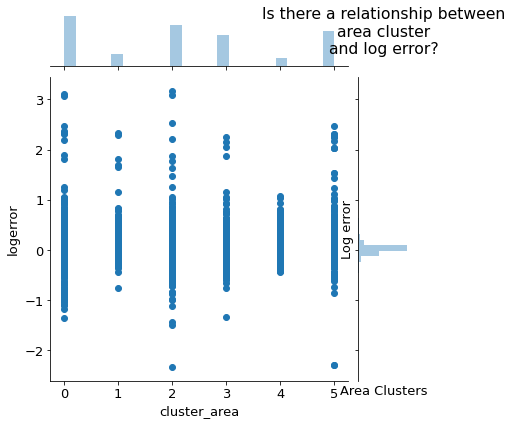

In [41]:
sns.jointplot(x="cluster_area", y="logerror", data=train)
plt.xlabel("Area Clusters")
plt.ylabel("Log error")
plt.title("Is there a relationship between\narea cluster\nand log error?\n")
plt.show()

In [42]:
train.cluster_area.value_counts()

0    5715
2    4782
5    4035
3    3599
1    1416
4     952
Name: cluster_area, dtype: int64

In [43]:
#train.loc[:,'cluster_area'] = train.cluster_area.astype(np.float)

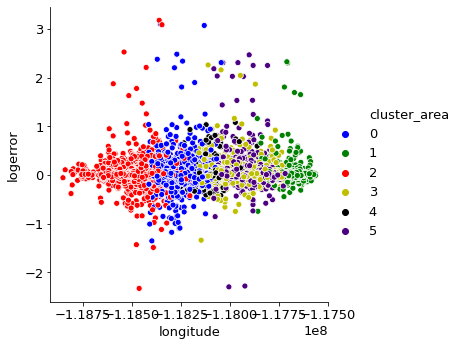

In [44]:
df = pd.DataFrame(data=train)
df["cluster_area"] = df["cluster_area"].astype(str)

sns.relplot(x='longitude', y='logerror', hue='cluster_area', data=df, 
            palette=["b", "g", "r", "y", "k", "indigo"])

plt.show()

Add feature: is_cluster_area_1 and focus on reducing log error there.

# Predictive Modeling

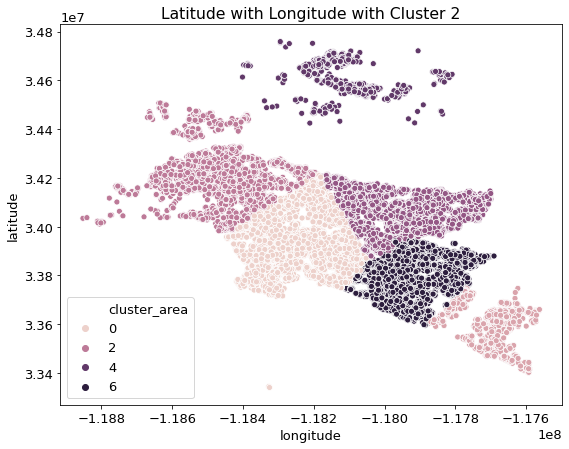

In [45]:
# use later, with hue = is_cluster_area_1?
sns.scatterplot(x='longitude', y='latitude', hue='cluster_area', data=train.drop(columns=['logerror']))
plt.title("Latitude with Longitude with Cluster 2")
plt.show()

# Predictive Modeling

### Our goal is to produce a regression model that outperforms the baseline in predicting the target value -- in this case, the assessed (e.g., not actual) value of a single-unit property.

I will:
 * define the baseline and evaluate it on train and validate data
 * use automated feature selection to choose features for models
 * decide if I want to create any new features based on existing features
 * decide whether to drop features
 * choose which algorithms and hyperparameters I'd like to use first
 * create, fit, and transform models
 * evaluate on validate then tweak hyperparameters if needed
 * evaluate my model(s) on the test data set
 * create a model.py file to make this Modeling reproducible

### Choose Features to use in Modeling with RFE (Recursive Feature Elimination)

In [46]:
# rescale the data for modeling
scaler, train_scaled, validate_scaled, test_scaled = zillow_scale(train, validate, test)
train_scaled.head(3)

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century,logerror,cluster_area
parcelid,,,,,,,,,,,,
13060986,0.50,0.58,0.49,0.81,0.00,0.63,0.14,0.60,0.67,0.00,0.42,0.60
11921805,0.50,0.44,0.56,0.60,0.00,0.26,0.22,0.50,0.33,0.00,0.43,0.60
11504971,0.75,0.62,0.39,0.35,0.00,0.64,0.03,0.80,0.67,0.00,0.43,0.00


In [47]:
train_scaled.describe()

,bathcnt,sqft,latitude,longitude,county,yearbuilt,value,bathbedcnt,decade,century,logerror,cluster_area
count,"20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00","20,499.00"
mean,0.50,0.41,0.46,0.56,0.27,0.55,0.09,0.51,0.59,0.00,0.43,0.45
std,0.17,0.15,0.17,0.20,0.44,0.18,0.07,0.13,0.19,0.00,0.03,0.36
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.50,0.30,0.35,0.39,0.00,0.46,0.04,0.40,0.44,0.00,0.42,0.00
50%,0.50,0.38,0.45,0.57,0.00,0.53,0.08,0.50,0.56,0.00,0.42,0.40
75%,0.62,0.50,0.57,0.71,1.00,0.66,0.12,0.60,0.67,0.00,0.43,0.60
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00


In [48]:
train_scaled.columns

Index(['bathcnt', 'sqft', 'latitude', 'longitude', 'county', 'yearbuilt',
       'value', 'bathbedcnt', 'decade', 'century', 'logerror', 'cluster_area'],
      dtype='object')

In [49]:
k = 6

# create and fit linear regression object
lm = LinearRegression(normalize = True)
lm.fit(train_scaled.drop(columns=['logerror']), train_scaled.logerror)
# create and fit the rfe object
rfe = RFE(lm, k)
rfe.fit(train_scaled.drop(columns=['logerror']), train_scaled.logerror)
train_scaled.drop(columns=['logerror']).columns[rfe.support_]

rfe.support_

array([ True,  True, False, False, False,  True,  True,  True,  True,
       False, False])

In [50]:
print('RFE Selected Features:\n', train.drop(columns=['logerror']).columns[rfe.support_])

RFE Selected Features:
 Index(['bathcnt', 'sqft', 'yearbuilt', 'value', 'bathbedcnt', 'decade'], dtype='object')


Re-do with next iteration

**Based on my RFE results, I will use bathbedcnt, century and cluster_area as predicter features.**

**I won't use bathcnt or county because the feature redundancy from overlap could overfit my model by effectively giving more weight to some features.**

## Define and Evaluate Baseline

In [51]:
np.median(train.logerror)
#np.mean(train.logerror)

0.00583204246769

**I'm going to go with the median as a baseline prediction for log error since I still have some outliers present in my data.**

In [52]:
baseline = train.logerror.median()

baseline_rmse_train = round(mean_squared_error(train.logerror, np.full(len(train.logerror), baseline))**1/2, 6)
print('RMSE (Root Mean Square Error) of Baseline on train data:\n', baseline_rmse_train)
baseline_rmse_validate = round(mean_squared_error(validate.logerror, np.full(len(validate.logerror), baseline))**1/2, 6)
print('RMSE (Root Mean Square Error) of Baseline on validate data:\n', baseline_rmse_validate)

RMSE (Root Mean Square Error) of Baseline on train data:
 0.012386
RMSE (Root Mean Square Error) of Baseline on validate data:
 0.012965


## Make Models, Evaluate Models, and Test Models

### Ordinary Least Squares (OLS) using Linear Regression

In [53]:
# X_train = train_scaled.drop(columns=['logerror'])
# y_train = train_scaled.logerror

# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data.
lm.fit(train_scaled.drop(columns=['logerror']), train_scaled.logerror)

# predict on train
lm_pred = lm.predict(train_scaled.drop(columns=['logerror']))
# compute root mean squared error
lm_rmse = mean_squared_error(train_scaled.logerror, lm_pred)**1/2

# predict on validate
lm_pred_v = lm.predict(validate_scaled.drop(columns=['logerror']))
# compute root mean squared error
lm_rmse_v = mean_squared_error(validate_scaled.logerror, lm_pred_v)**1/2

print("RMSE for OLS using LinearRegression\n\nOn train data:\n", round(lm_rmse, 6), '\n\n', 
      "On validate data:\n", round(lm_rmse_v, 6))

RMSE for OLS using LinearRegression

On train data:
 0.000405 

 On validate data:
 0.000425


**This model performs better than the baseline. Yay!**

# Conclusion and Takeaways - How to prevent future error in Zestimates

To-do list:
* remove outliers with isolation forest
* make cluster_area into dummy variables
* change statistical test to be better regarding the distribution of years
* turn cluster_area into dummy variables (i.e. is_cluster_area_1, is_cluster_area_2, etc.)
* takeaways and conclusions on how where to focus efforts to reduce log error
* read my notes
* read the project specs
* put remaining notebook code into functions
* add two more models
* test the best model on test data
* copy comments from acquire and prepare code into presentation notebook
* practice presentation and make script/notes
* title and label visualizations better
* geo.py implementation if extra time